<h1>Different types of regression</h1>

In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from matplotlib.colors import ListedColormap
from IPython.display import HTML
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.datasets import load_iris
import warnings
warnings.filterwarnings('ignore')

<p>This notebook is dedicated to the construction of various regression models, such as linear regression, polynomial regression, Tikhonov regularization, logistic regression, and multi-variable regression. We will compare the results of the built models with the models of the scikit-learn library.</p>

<h2>Linear regression</h2>

<p>Let's consider the simplest regression model - linear regression. This model predicts the target attribute $y$ from the non target attribute $x$: \begin{equation} \hat{y} = x \cdot w + b \end{equation}, where $w$ and $b$ are the model parameters. In this formula $x$ is a columns of data, $w$ is a column of coefficients. This refers to matrix multiplication. To find the optimal parameters, we will minimize the loss function called the mean squared error (MSE): \begin{equation} \large\frac{1}{n} \sum_{i=1}^n (\hat{y} - y) \end{equation}</p>

<p>In all models, except the last one, we will provide input data in the form of feature rows, not columns. In scikit-learn it's columns of features, as it should be.</p>

In [2]:
class SimpleLinearRegression:
    
    def init_EMAs(self, input_size):
        self.EMA_adam1_w = np.zeros((1, input_size), dtype=float)
        self.EMA_adam2_w = np.zeros((1, input_size), dtype=float)
        self.EMA_adam1_b = np.zeros(1, dtype=float)
        self.EMA_adam2_b = np.zeros(1, dtype=float)
    
    def init_vels(self, input_size):
        self.vel_w = np.zeros((1, input_size), dtype=float)
        self.vel_b = np.zeros(1, dtype=float)
    
    def init_weights(self, input_size): 
        self.w = np.random.normal(0, 0.01, (1, input_size))
        self.b = np.zeros(1, dtype=float)
    
    def MSE(self, y_pred, y):
        return ((y_pred - y) ** 2).sum() / y.shape[0] #MSE
    
    def w_grad(self, X, y):
        return np.array([(2 * X.T @ (X @ self.w.T + self.b - y)).sum(axis=1) / X.shape[0]])
    
    def b_grad(self, X, y):
        return np.array([(2 * (X @ self.w.T + self.b - y)).sum() / X.shape[0]])
        
    def fit(self, X, y, lr=0.001, num_epochs=10000, beta=0.9, optimizer='SGD', beta1=0.9, beta2=0.999, eps=10e-9):
        self.init_weights(X.shape[0])
        mse_history = []
        weights_history = []
        mse_history.append(self.MSE(self.predict(X), y.T))
        weights_history.append([self.w.tolist(), self.b.item()])
        if optimizer == 'Stochastic':
            for _ in range(num_epochs):
                self.w -= lr * self.w_grad(X.T, y.T)
                self.b -= lr * self.b_grad(X.T, y.T)
                if _ % 100 == 0:
                    mse_history.append(self.MSE(self.predict(X), y.T))
                    weights_history.append([self.w.tolist(), self.b.item()])
        if optimizer == 'SGD':
            self.init_vels(X.shape[0])
            for _ in range(num_epochs):
                next_vel_w = beta * self.vel_w + lr * self.w_grad(X.T, y.T)
                next_vel_b = beta * self.vel_b + lr * self.b_grad(X.T, y.T)
                self.w -= next_vel_w
                self.b -= next_vel_b
                self.vel_w = next_vel_w
                self.vel_b = next_vel_b
                if _ % 100 == 0:
                    mse_history.append(self.MSE(self.predict(X), y.T))
                    weights_history.append([self.w.tolist(), self.b.item()])
        elif optimizer == 'ADAM':
            self.init_EMAs(X.shape[0])
            for _ in range(num_epochs):
                next_EMA1_w = (1 - beta1) * self.w_grad(X.T, y.T) + beta1 * self.EMA_adam1_w
                next_EMA2_w = (1 - beta2) * (self.w_grad(X.T, y.T)) ** 2 + beta2 * self.EMA_adam2_w
                next_EMA1_b = (1 - beta1) * self.b_grad(X.T, y.T) + beta1 * self.EMA_adam1_b
                next_EMA2_b = (1 - beta2) * (self.b_grad(X.T, y.T)) ** 2 + beta2 * self.EMA_adam2_b
                self.w -= lr * next_EMA1_w / (np.sqrt(next_EMA2_w) + eps)
                self.b -= lr * next_EMA1_b / (np.sqrt(next_EMA2_b) + eps)
                self.EMA_adam1_w = next_EMA1_w
                self.EMA_adam2_w = next_EMA2_w
                self.EMA_adam1_b = next_EMA1_b
                self.EMA_adam2_b = next_EMA2_b
                if _ % 100 == 0:
                    mse_history.append(self.MSE(self.predict(X), y.T))
                    weights_history.append([self.w.tolist(), self.b.item()])           
        return np.array(mse_history), np.array(weights_history)

    def predict(self, X):
        return X.T @ self.w.T + self.b

<p>Let's try using the class described above to predict a noisy function: \begin{equation} y = 4 - 3 \cdot x \end{equation}</p>

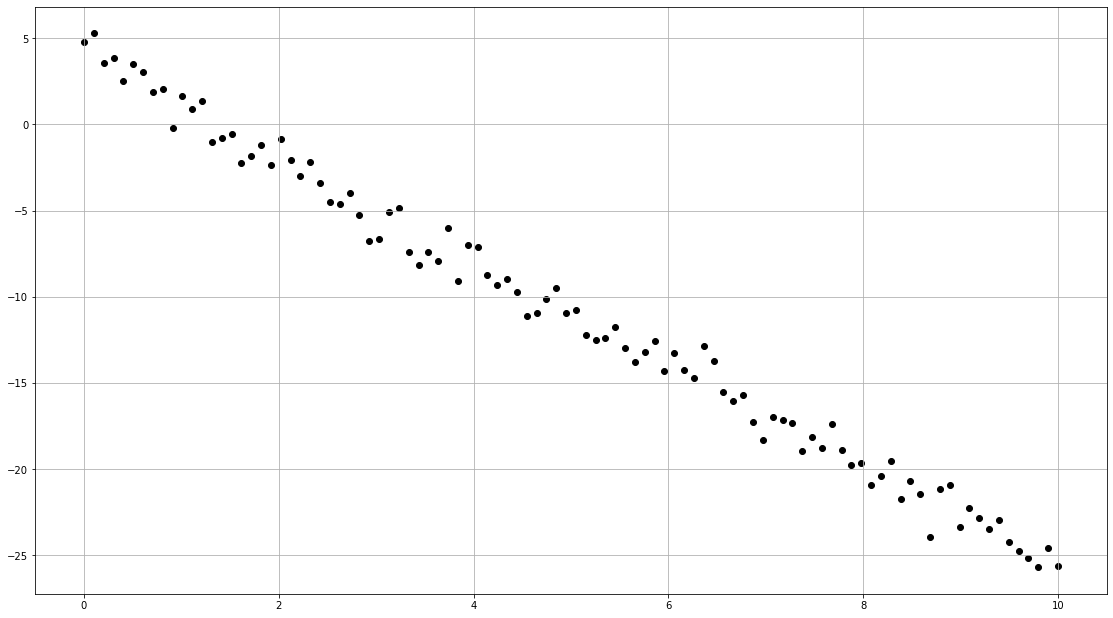

In [3]:
data = pd.DataFrame({'X':np.linspace(0, 10, 100),
                    'y':4 - 3 * np.linspace(0, 10, 100) + np.random.normal(size=100)})
fig, ax = plt.subplots(figsize=(19.20, 10.80))
ax.scatter(np.array(data.X), np.array(data.y), color='black')
ax.grid()
plt.show()

<p>In order for the optimization algorithm to better find the minimum, the features are scaled. In this case, we will not scale them. Let's now plot a figure for MSE without feature scaling.</p>

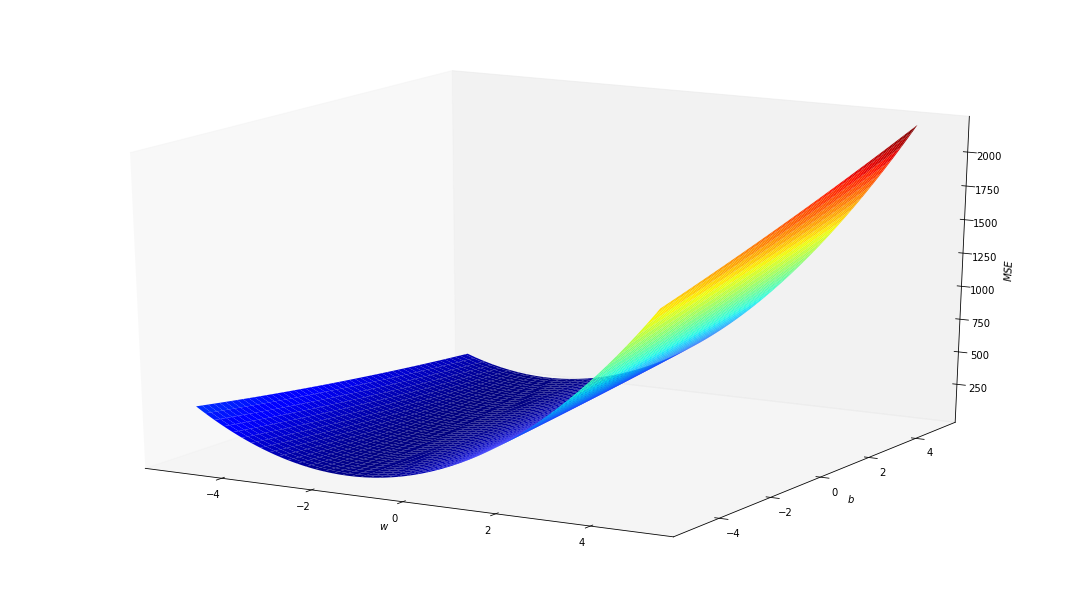

In [4]:
x_for_mse = np.array(data.X)
y_for_mse = np.array(data.y)
w_for_mse = np.linspace(-5, 5, 100)
b_for_mse = np.linspace(-5, 5, 100)
mse = []
helper = []
for j in range(len(w_for_mse)):
    for i in range(len(b_for_mse)):
        helper.append(((x_for_mse * w_for_mse[i] + b_for_mse[j] - y_for_mse) ** 2).mean())
    mse.append(helper)
    helper = []
mse = np.array(mse)
w_for_mse, b_for_mse = np.meshgrid(w_for_mse, b_for_mse)
fig = plt.figure(figsize=(19.20, 10.80))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(w_for_mse, b_for_mse, mse, cmap='jet')
ax.grid(False)
ax.view_init(20, -60)
ax.set_xlabel('$w$')
ax.set_ylabel('$b$')
ax.set_zlabel('$MSE$', rotation=180)
plt.show()

<p>Let's create an object of our Simple Linear Regression class and train it on the data described above using the ADAM optimization method.</p>

In [5]:
sim_lin_reg = SimpleLinearRegression()
history, weights_history = sim_lin_reg.fit(np.array([data.X]),\
                                           np.array([data.y]), lr=0.01, optimizer='ADAM')

<p>The following cells are needed for amination.</p>

In [6]:
path = []
helper = []
for i in range(len(weights_history)):
    helper.append(weights_history[i][0][0][0])
    helper.append(weights_history[i][1])
    path.append(helper)
    helper = []
path = np.array(path).T

In [7]:
def init():
    line.set_data([], [])
    line.set_3d_properties([])
    point.set_data([], [])
    point.set_3d_properties([])
    return line, point

def animate(i):
    line.set_data(path[0,:i], path[1,:i])
    line.set_3d_properties(history[:i])
    point.set_data(path[0,i-1:i], path[1,i-1:i])
    point.set_3d_properties(history[i])
    return line, point

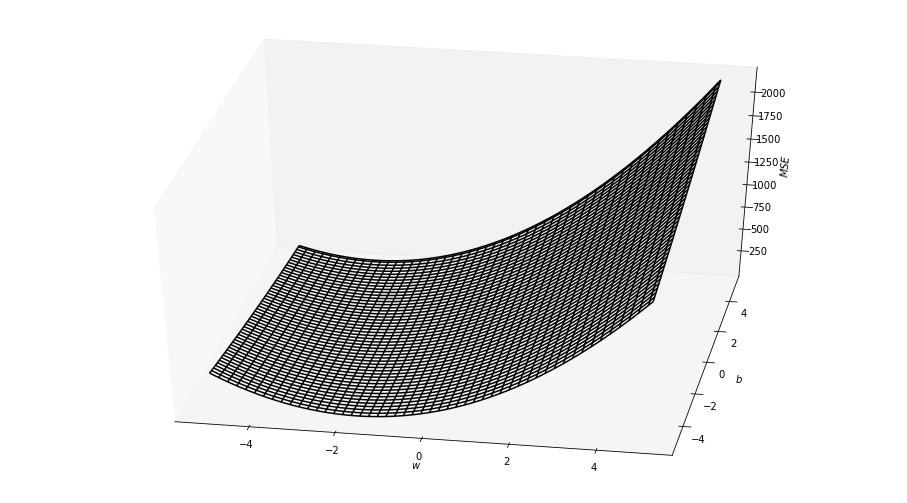

In [8]:
fig = plt.figure(figsize=(16., 9.))
ax = fig.add_subplot(projection='3d')
ax.plot_wireframe(w_for_mse, b_for_mse, mse, edgecolor='black')
ax.grid(False)
ax.view_init(40, -80)
ax.set_xlabel('$w$')
ax.set_ylabel('$b$')
ax.set_zlabel('$MSE$', rotation=180)
line, = ax.plot([], [], [], color='red', lw=2)
point, = ax.plot([], [], [], color='red', marker='o')
plt.show()

In [9]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=path.shape[1], interval=60, 
                               repeat_delay=5, blit=True)

In [10]:
HTML(anim.to_html5_video())

In [11]:
# anim.save('./regr.mp4')

In [12]:
def init():
    line.set_data([], [])
    point.set_data([], [])
    return line, point

def animate(i):
    line.set_data(path[0,:i], path[1,:i])
    point.set_data(path[0,i-1:i], path[1,i-1:i])
    return line, point

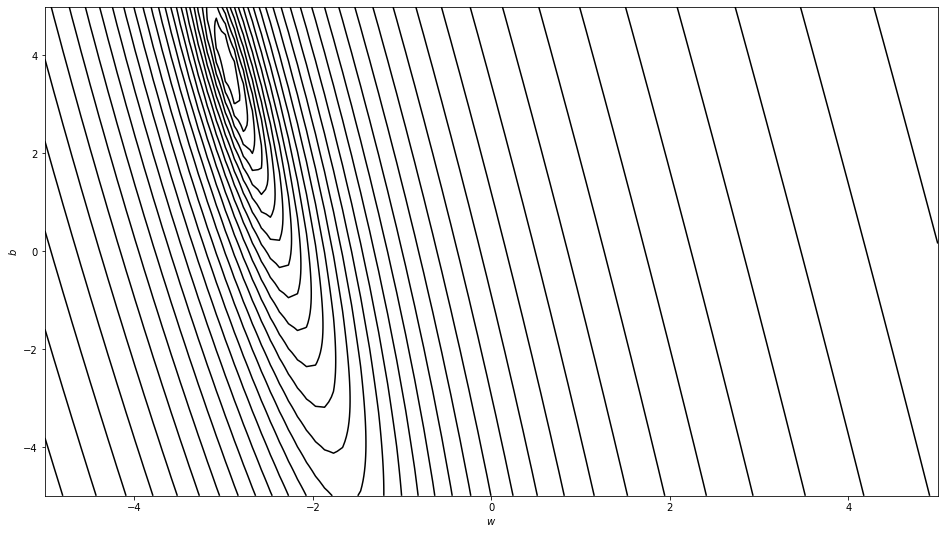

In [13]:
fig, ax = plt.subplots(figsize=(16., 9.))
ax.contour(w_for_mse, b_for_mse, mse, levels=np.logspace(0, 5, 50), colors='black')
line, = ax.plot([], [], color='red')
point, = ax.plot([], [], color='red', marker='o')
ax.set_xlabel('$w$')
ax.set_ylabel('$b$')
plt.show()

In [14]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=path.shape[1], interval=60, 
                               repeat_delay=5, blit=True)

In [15]:
HTML(anim.to_html5_video())

In [16]:
# anim.save('./reg1.mp4')

<p>As we can see on the animations showed above, our algorithm works, it finds the minimum of the loss function.</p>

<p>Let's now plot the prediction curve above the training dots.</p>

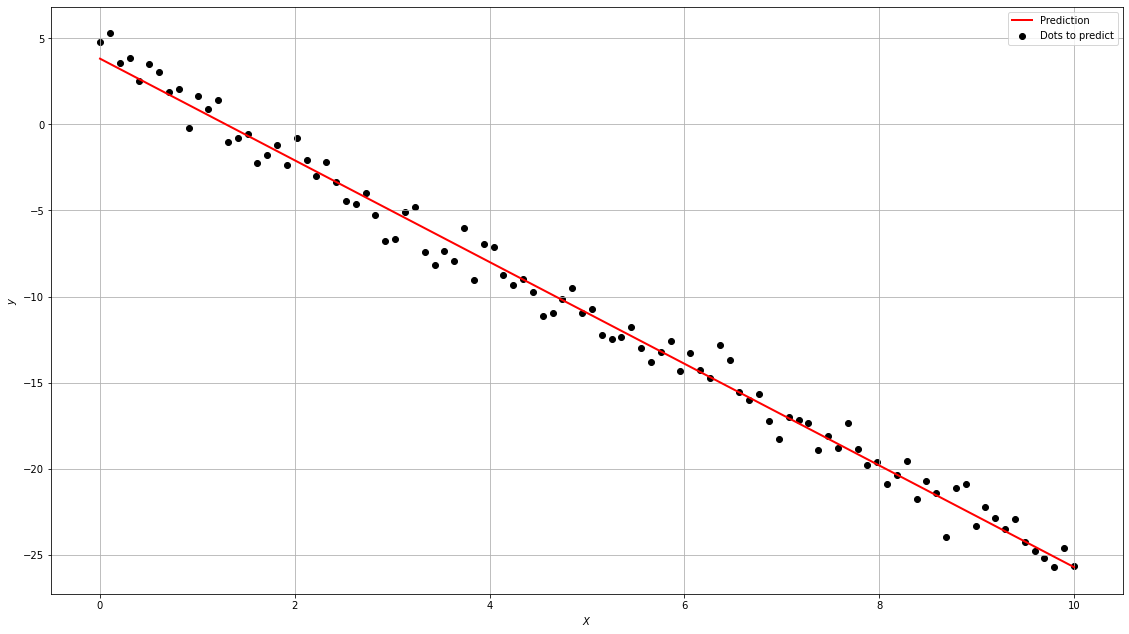

In [17]:
fig, ax = plt.subplots(figsize=(19.20, 10.80))
ax.scatter(np.array(data.X), np.array(data.y), marker='o', color='black', label='Dots to predict')
ax.plot(np.array([np.linspace(0, 10, 100)]).T, sim_lin_reg.predict(np.array([np.linspace(0, 10, 100)])), color='red',\
       linewidth=2, label='Prediction')
ax.grid()
ax.legend(loc='upper right')
ax.set_xlabel('$X$')
ax.set_ylabel('$y$')
plt.show()

<p>Now, to compare the performance of our algorithm, let's build a model from the scikit-learn library</p>

In [18]:
skl_reg = LinearRegression()
skl_reg.fit(np.array([data.X]).T, np.array([data.y]).T)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

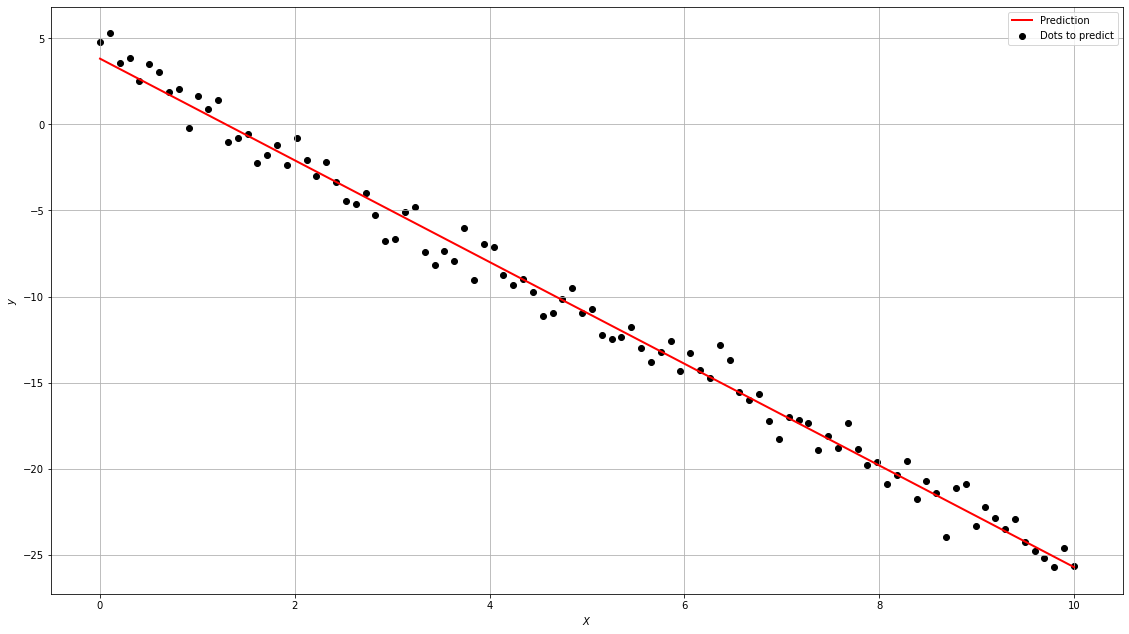

In [19]:
fig, ax = plt.subplots(figsize=(19.20, 10.80))
ax.scatter(np.array(data.X), np.array(data.y), marker='o', color='black', label='Dots to predict')
ax.plot(np.array([data.X]).T, skl_reg.predict(np.array([data.X]).T), color='red',\
       linewidth=2, label='Prediction')
ax.grid()
ax.legend(loc='upper right')
ax.set_xlabel('$X$')
ax.set_ylabel('$y$')
plt.show()

In [20]:
print('My model coefs = {0}, bias = {1}.\nsklearn\'s coef_ = {2}, intercept_ = {3}'.\
      format(sim_lin_reg.w, sim_lin_reg.b, skl_reg.coef_, skl_reg.intercept_))

My model coefs = [[-2.9523841]], bias = [3.81219143].
sklearn's coef_ = [[-2.9523841]], intercept_ = [3.81219143]


<p>As we can see, the coefficients of our model coincide with the sklearn coefficients with a certain accuracy.</p>

<h2>Polynomial regression</h2>

<p>Now let's complicate the problem a little, and try to build a model of polynomial regression: \begin{equation} \hat{y} = b + x \cdot w_{1} + x^{2} \cdot w_{2} + ... + x^{k} \cdot w_{k} \end{equation} This problem consists in approximating our target feature by a polynomial of degree $k$.</p>

<p>We perform the same steps as we did above, let's approximate the following function with noise added: \begin{equation} y = 2 + x + 0.5 \cdot x^{2} \end{equation}</p>

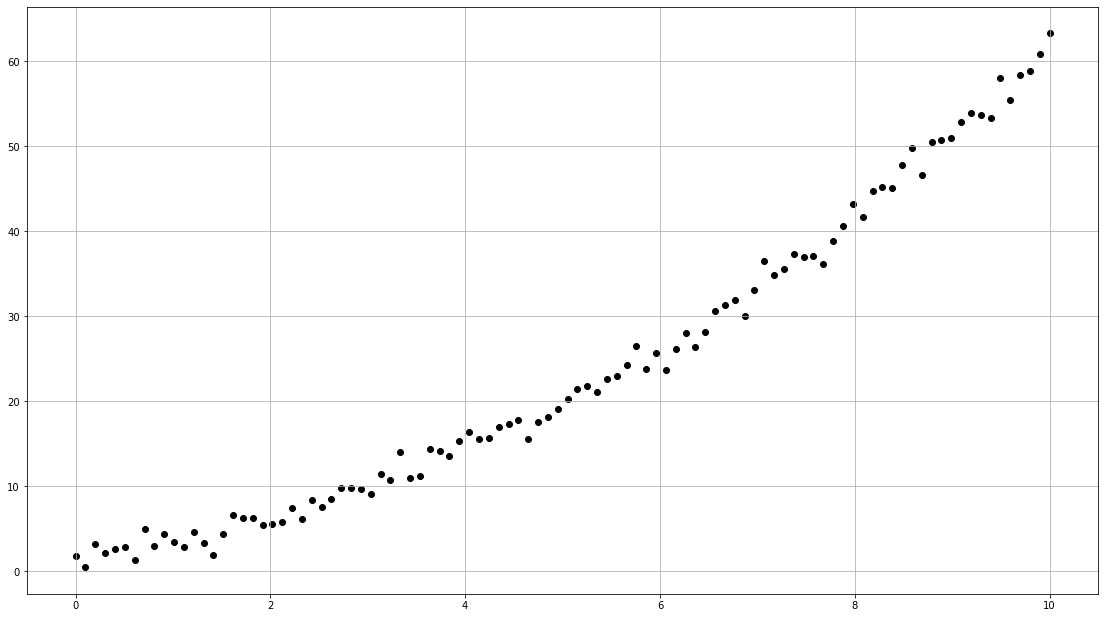

In [21]:
data = pd.DataFrame({'X1':np.linspace(0, 10, 100),
                     'X2':np.linspace(0, 10, 100) ** 2,
                    'y': 2 + np.linspace(0, 10, 100) + 0.5 * np.linspace(0, 10, 100) ** 2 + np.random.normal(size=100)})
pol_reg = SimpleLinearRegression()
fig, ax = plt.subplots(figsize=(19.20, 10.80))
ax.scatter(np.array(data.X1), np.array(data.y), color='black')
ax.grid()
plt.show()

In [22]:
pol_reg = SimpleLinearRegression()
history, weights_history = pol_reg.fit(np.array([data.X1, data.X2]),\
                                       np.array([data.y]), lr=3e-4, num_epochs=100000, optimizer='ADAM')

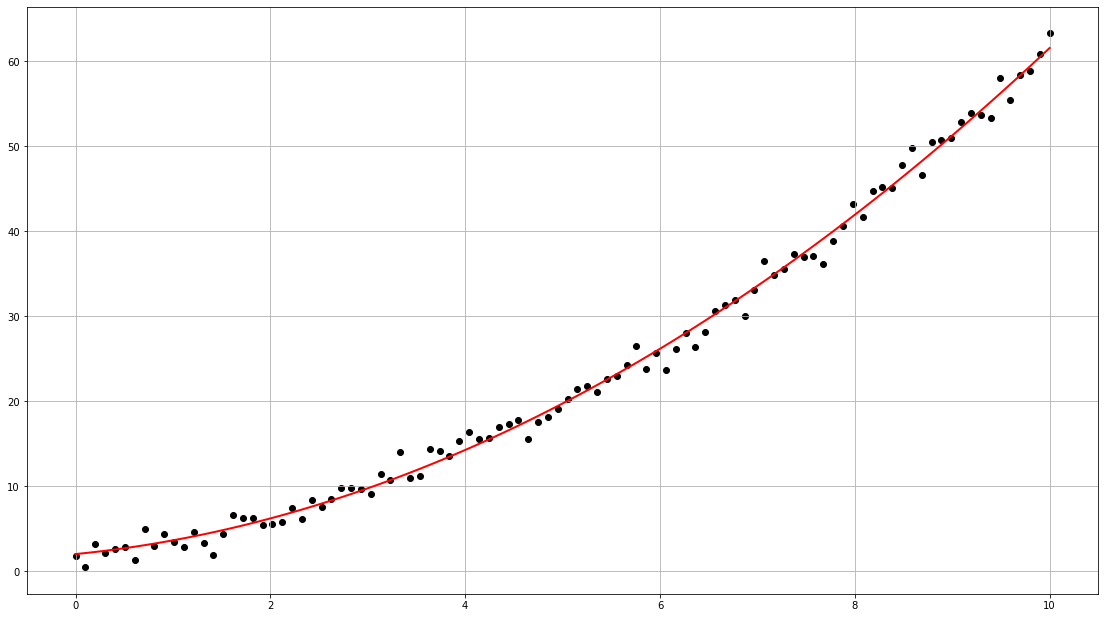

In [23]:
fig, ax = plt.subplots(figsize=(19.20, 10.80))
ax.scatter(np.array(data.X1), np.array(data.y), marker='o',color='black')
ax.plot(np.array([np.linspace(0, 10, 100)]).T, pol_reg.predict(np.array([data.X1,\
                                                                         data.X2,\
                                                                         ])), color='red',\
       linewidth=2)
ax.grid()
plt.show()

In [24]:
pol_skl = LinearRegression()
pol_skl.fit(np.array([data.X1, data.X2]).T, np.array([data.y]).T)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

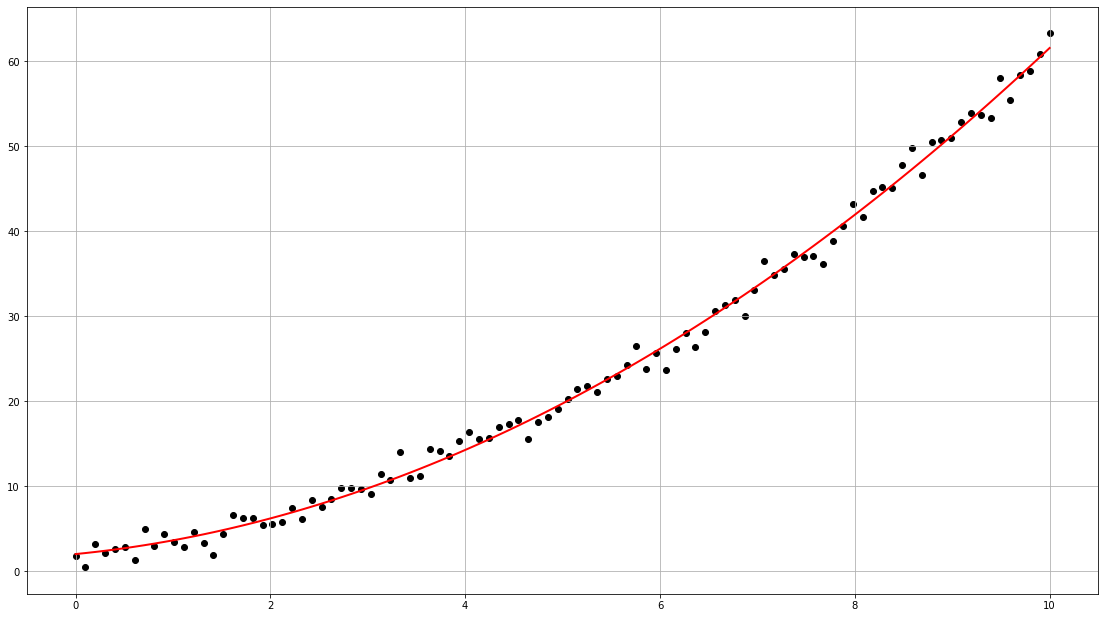

In [25]:
fig, ax = plt.subplots(figsize=(19.20, 10.80))
ax.scatter(np.array(data.X1), np.array(data.y), marker='o',color='black')
ax.plot(np.array([np.linspace(0, 10, 100)]).T, pol_skl.predict(np.array([data.X1,\
                                                                         data.X2]).T), color='red',\
       linewidth=2)
ax.grid()
plt.show()

In [26]:
print('My model coefs = {0}, bias = {1}.\nsklearn\'s coef_ = {2}, intercept_ = {3}'.\
      format(pol_reg.w, pol_reg.b, pol_skl.coef_, pol_skl.intercept_))

My model coefs = [[1.13391577 0.48171517]], bias = [2.04944736].
sklearn's coef_ = [[1.13392044 0.48171984]], intercept_ = [2.04945202]


<p>As we can see, the coefficients of our model coincide with the sklearn coefficients with a certain accuracy.</p>

<h2>Regularization</h2>

<p>Next we implement the Tikhonov regularization or it is also called ridge regularization. Regularization consists in adding a regularization term to the loss function during training, so that means we minimize MSE with regularization term: \begin{equation} \large\frac{1}{n} \sum_{i=1}^n (\hat{y} - y) + \alpha\sum_{i=1}^n w_{i}^{2} \end{equation} In case of Ridge regularization the added term is the sum of squared coefficients excluding bias term ($b$). To see the performance of algorithm we use the MSE without the added term! This term is only used for training.</p>

In [27]:
class RidgeRegression(SimpleLinearRegression):
    
    def __init__(self, alpha=0.5):
        self.alpha = alpha    
    
    def w_grad(self, X, y):
        return np.array([(2 * X.T @ (X @ self.w.T + self.b - y)).sum(axis=1) / X.shape[0]\
                         + (self.alpha * 2 * self.w).reshape(-1)])

    def fit(self, X, y, lr=0.001, num_epochs=10000, beta1=0.9, beta2=0.999, eps=10e-9):
        self.init_weights(X.shape[0])
        loss_history = []
        weights_history = []
        loss_history.append(self.MSE(self.predict(X), y.T))
        weights_history.append([self.w.tolist(), self.b.item()])
        self.init_EMAs(X.shape[0])
        for _ in range(num_epochs):
            next_EMA1_w = (1 - beta1) * self.w_grad(X.T, y.T) + beta1 * self.EMA_adam1_w
            next_EMA2_w = (1 - beta2) * (self.w_grad(X.T, y.T)) ** 2 + beta2 * self.EMA_adam2_w
            next_EMA1_b = (1 - beta1) * self.b_grad(X.T, y.T) + beta1 * self.EMA_adam1_b
            next_EMA2_b = (1 - beta2) * (self.b_grad(X.T, y.T)) ** 2 + beta2 * self.EMA_adam2_b
            self.w -= lr * next_EMA1_w / (np.sqrt(next_EMA2_w) + eps)
            self.b -= lr * next_EMA1_b / (np.sqrt(next_EMA2_b) + eps)
            self.EMA_adam1_w = next_EMA1_w
            self.EMA_adam2_w = next_EMA2_w
            self.EMA_adam1_b = next_EMA1_b
            self.EMA_adam2_b = next_EMA2_b
            if _ % 100 == 0:
                loss_history.append(self.MSE(self.predict(X), y.T))
                weights_history.append([self.w.tolist(), self.b.item()])           
        return np.array(loss_history), np.array(weights_history)

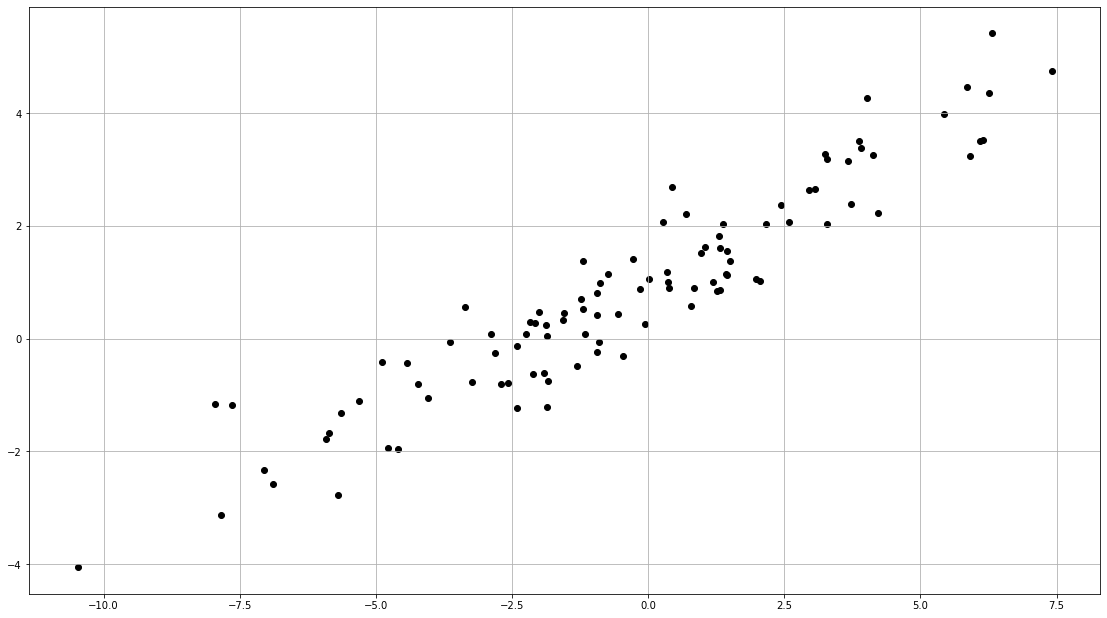

In [28]:
np.random.seed(42)
X_1 = 4 * np.random.randn(100)
X_new = np.linspace(-3, 3, 100)
y = 1 + 0.5 * X_1 + np.random.randn(100) / 1.5
fig, ax = plt.subplots(figsize=(19.20, 10.80))
ax.scatter(X_1, y, color='black')
ax.grid()
plt.show()

<p>It's important to use scaled features for Regularization. For this we will use sklearn StandardScaler(): \begin{equation} z = \frac{x – \mu}{\sigma} \end{equation}</p>

In [29]:
scaler = StandardScaler()
poly = PolynomialFeatures(10, include_bias=False)
X = scaler.fit_transform(poly.fit_transform(np.array([X_1]).T)).T
X_n = poly.fit_transform(np.array([X_new]).T).T

<p>Let's now build models with different alphas.</p>

With alpha = 0, w = [[  1.72151001   0.32634657  -0.10159588   1.45439929   2.69886617
  -10.55519414  -8.72211923  18.79110847   7.81317288  -8.29650343]], b = [0.80717669], Loss function = 0.35168167391075955
With alpha = 0.01, w = [[ 1.69888508  0.16655082  0.20428441  0.01713381 -0.28181576  0.04723387
  -0.13710168 -0.07152728  0.09885337 -0.23462357]], b = [0.80717665], Loss function = 0.36506907157057017
With alpha = 0.5, w = [[ 0.91040202  0.07566353  0.41626866  0.04983241  0.13775096  0.03805939
   0.03041666  0.03171398 -0.00559833  0.02777819]], b = [0.80717669], Loss function = 0.6609622239643936
With alpha = 1.5, w = [[0.55362629 0.02580089 0.30850677 0.00781407 0.13187868 0.0039785
  0.04933533 0.00498199 0.01555634 0.00653073]], b = [0.80717971], Loss function = 1.1987227290851687
With alpha = 10.0, w = [[ 0.14095659 -0.01242754  0.09777399 -0.0214652   0.05809935 -0.02281845
   0.036709   -0.02170727  0.02693736 -0.02050389]], b = [0.80717669], Loss function = 2.460323

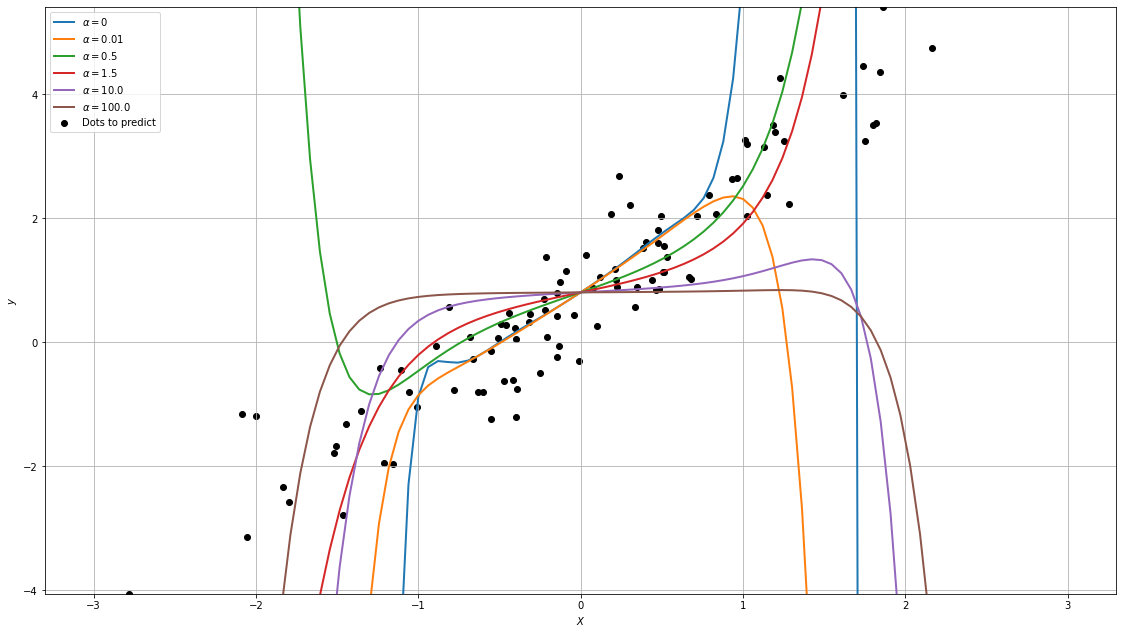

In [30]:
fig, ax = plt.subplots(figsize=(19.20, 10.80))
ax.scatter(X[0], y, marker='o', color='black', label='Dots to predict')
for alpha in [0, 0.01, 0.5, 1.5, 10., 100.]:
    ridge_reg = RidgeRegression(alpha=alpha)
    history, weights_history = ridge_reg.fit(X, np.array([y]), lr=3e-4, num_epochs=100000)
    ax.plot(X_n[0].T, ridge_reg.predict(X_n)\
            , linewidth=2, label=r'$\alpha = {}$'.format(alpha))
    plt.ylim([y.min(), y.max()])
    print(r'With alpha = {0}, w = {1}, b = {2}, Loss function = {3}'\
          .format(alpha, ridge_reg.w, ridge_reg.b, history[-1]))
ax.grid()
ax.legend(loc='upper left')
ax.set_xlabel('$X$')
ax.set_ylabel('$y$')
plt.show()

<p>And compare the performance of our algorithm with sklearn Ridge. As we can see both algorithms work the same. Blue with dots of sklearn and our orange.</p>

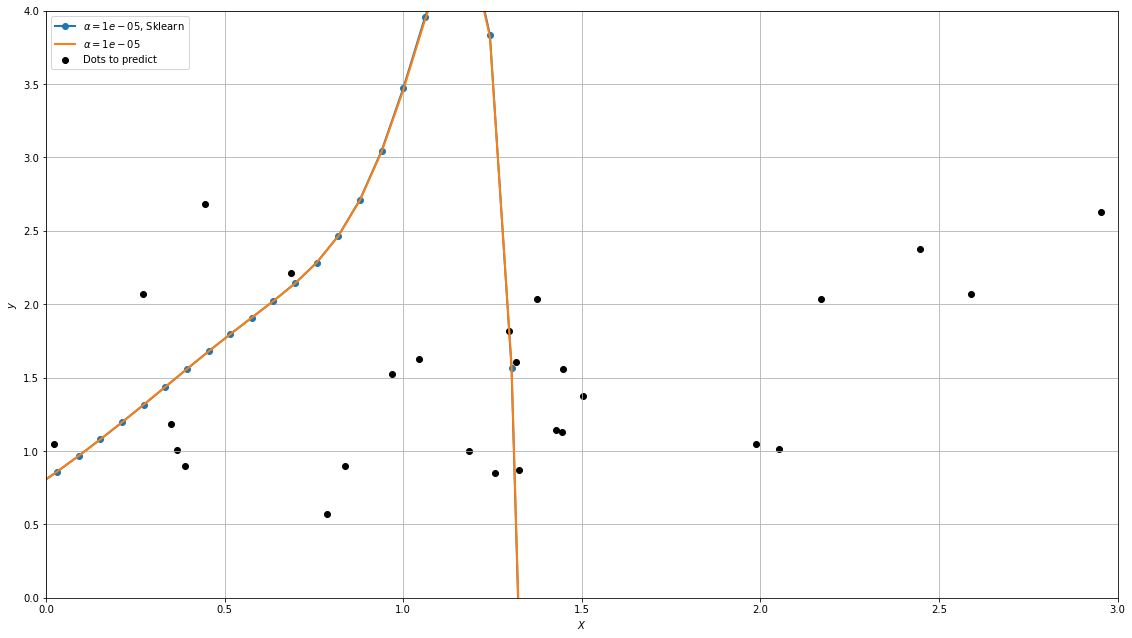

In [31]:
alpha = 1e-5
ridge_reg = RidgeRegression(alpha=alpha)
history, weights_history = ridge_reg.fit(X, np.array([y]), lr=3e-4, num_epochs=100000)
ridge_skl = Ridge(alpha=alpha, normalize=True)
ridge_skl.fit(X.T, np.array([y]).T)
fig, ax = plt.subplots(figsize=(19.20, 10.80))
ax.scatter(X_1, y, marker='o', color='black', label='Dots to predict')
ax.plot(X_n[0].T, ridge_skl.predict(X_n.T)\
        , linewidth=2, marker='o', label=r'$\alpha = {}$, Sklearn'.format(alpha))
ax.plot(X_n[0].T, ridge_reg.predict(X_n)\
        , linewidth=2, label=r'$\alpha = {}$'.format(alpha))
plt.axis([0, 3, 0, 4])
ax.grid()
ax.legend(loc='upper left')
ax.set_xlabel('$X$')
ax.set_ylabel('$y$')
plt.show()

<h2>Logistic Regression</h2>

<p>Let's consider a regression model that solves the problem of binary classification. The logistic regression model calculates the weighted sum of input features, just like the linear regression model does, but instead of producing results directly, it outputs the logistics of the result: \begin{equation} \hat{p} = \sigma(x \cdot w + b) \end{equation} Where $\sigma$ is sigmoid function: \begin{equation} \sigma(t) = \frac{1}{1 + exp(-t)} \end{equation} The values of the sigmoid function are in the range from 0 to 1, which means that they can be interpreted as the probability of being assigned to one or another class. For training models we use a loss function called Logoss: \begin{equation} \large-\frac{1}{n} \sum_{i=1}^n [y \cdot log(\hat{p}) + (1 - y) \cdot log(1 - \hat{p})] \end{equation}</p>

In [225]:
class LogRegression:
    
    def init_EMAs(self, input_size):
        self.EMA_adam1_w = np.zeros((1, input_size), dtype=float)
        self.EMA_adam2_w = np.zeros((1, input_size), dtype=float)
        self.EMA_adam1_b = np.zeros(1, dtype=float)
        self.EMA_adam2_b = np.zeros(1, dtype=float)
    
    def init_weights(self, input_size): 
        self.w = np.random.normal(0, 0.01, (1, input_size))
        self.b = np.zeros(1, dtype=float)
        
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))
    
    def LogLoss(self, y_pred, y):
        return -(y * np.log(self.sigmoid(y_pred)) + (1 - y) * np.log(1 - self.sigmoid(y_pred))).sum() / y.shape[0]
    
    def w_grad(self, X, y):
        return (X * (self.sigmoid(X @ self.w.T + self.b) - y)).sum(axis=0) / y.shape[0]
    
    def b_grad(self, X, y):
        return (self.sigmoid(X @ self.w.T + self.b) - y).sum() / y.shape[0]
        
    def fit(self, X, y, lr=3e-4, num_epochs=100000, beta1=0.9, beta2=0.999, eps=10e-9):
        self.init_weights(X.shape[0])
        loss_history = []
        weights_history = []
        loss_history.append(self.LogLoss(self.predict(X), y.T))
        weights_history.append([self.w.tolist(), self.b.item()])
        self.init_EMAs(X.shape[0])
        for _ in range(num_epochs):
            next_EMA1_w = (1 - beta1) * self.w_grad(X.T, y.T) + beta1 * self.EMA_adam1_w
            next_EMA2_w = (1 - beta2) * (self.w_grad(X.T, y.T)) ** 2 + beta2 * self.EMA_adam2_w
            next_EMA1_b = (1 - beta1) * self.b_grad(X.T, y.T) + beta1 * self.EMA_adam1_b
            next_EMA2_b = (1 - beta2) * (self.b_grad(X.T, y.T)) ** 2 + beta2 * self.EMA_adam2_b
            self.w -= lr * next_EMA1_w / (np.sqrt(next_EMA2_w) + eps)
            self.b -= lr * next_EMA1_b / (np.sqrt(next_EMA2_b) + eps)
            self.EMA_adam1_w = next_EMA1_w
            self.EMA_adam2_w = next_EMA2_w
            self.EMA_adam1_b = next_EMA1_b
            self.EMA_adam2_b = next_EMA2_b
            if _ % 100 == 0:
                loss_history.append(self.LogLoss(self.predict(X), y.T))
                weights_history.append([self.w.tolist(), self.b.item()])           
        return np.array(loss_history), np.array(weights_history)

    def predict(self, X):
        return X.T @ self.w.T + self.b
    
    def class_prediction(self, X):
        scores = self.predict(X)
        indices = (scores > 0).astype(np.int64)
        return indices
    
    def predict_proba(self, X):
        return np.vstack([1 - self.sigmoid(self.predict(X)).T, self.sigmoid(self.predict(X)).T]).T

<p>For example we will classify irises.</p>

In [226]:
data = load_iris()
X = data.data[:, 3:]
y = (data['target'] == 2).astype(np.int64)

<p>Now, let's train our model, we use X.T, that means transposed X and np.array([y]) because we need rows of features and targets (only for my model).</p>

In [227]:
log_reg = LogRegression()
history, weights_history = log_reg.fit(X.T, np.array([y]))

<p>And plot the prediction curve, the more it close to up or down the more it sure in its decision.</p>

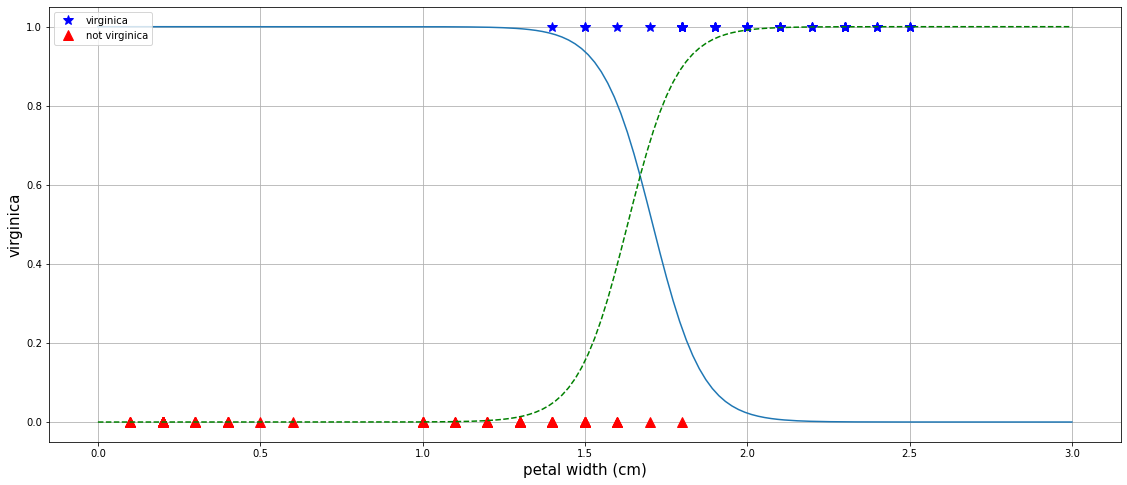

In [228]:
fig = plt.figure(figsize=(19.20, 8.))
ax = plt.axes()

ax.plot(X[y==1], y[y==1], 'b*', markersize=10, label=data.target_names[2])
ax.plot(X[y==0], y[y==0], 'r^', markersize=10, label='not %s'%data.target_names[2])
ax.plot(np.linspace(0, 3, 150), log_reg.sigmoid(1 - log_reg.predict(np.array([np.linspace(0, 3, 150)]))))
ax.plot(np.linspace(0, 3, 150), log_reg.sigmoid(log_reg.predict(np.array([np.linspace(0, 3, 150)]))), 'g--')
ax.set_xlabel(data.feature_names[3], fontsize=15)
ax.set_ylabel(data.target_names[2], fontsize=15)
ax.legend(loc='upper left')
ax.grid(True)
plt.show()

<p>And let's do the same for sklearn LogisticRegression.</p>

In [229]:
log_skl = LogisticRegression(penalty='none', solver='newton-cg')
log_skl.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

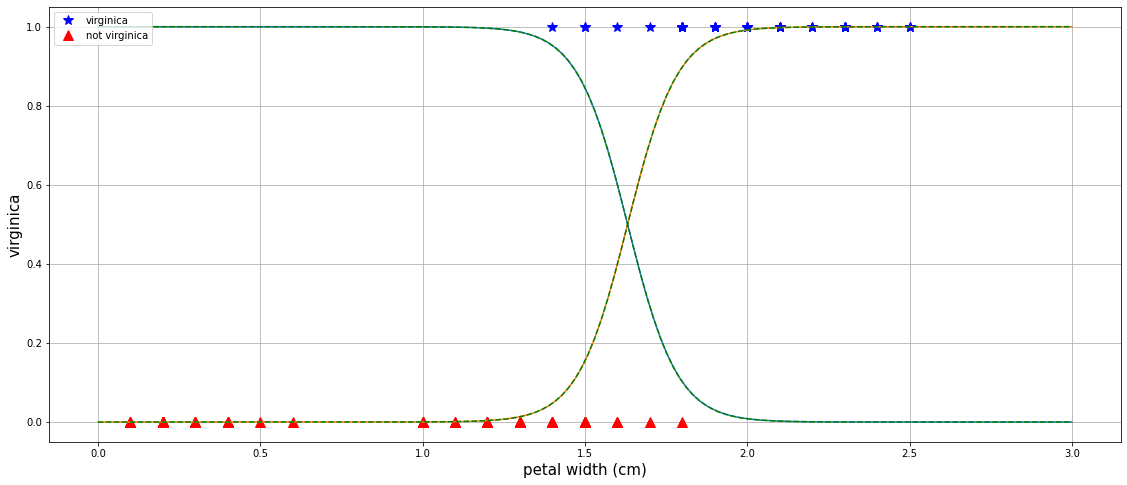

In [230]:
fig = plt.figure(figsize=(19.20, 8.))
ax = plt.axes()
ax.plot(X[y==1], y[y==1], 'b*', markersize=10, label=data.target_names[2])
ax.plot(X[y==0], y[y==0], 'r^', markersize=10, label='not %s'%data.target_names[2])
ax.plot(np.linspace(0, 3, 150), log_skl.predict_proba(np.linspace(0, 3, 150).reshape(-1, 1)))
ax.plot(np.linspace(0, 3, 150), (1 - log_skl.predict_proba(np.linspace(0, 3, 150).reshape(-1, 1))), 'g--')
ax.set_xlabel(data.feature_names[3], fontsize=15)
ax.set_ylabel(data.target_names[2], fontsize=15)
ax.legend(loc='upper left')
ax.grid(True)
plt.show()

<p>Comparison of coefficients and class predictions are showed below.</p>

In [231]:
print('My model coefs = {0}, bias = {1}.\nsklearn\'s coef_ = {2}, intercept_ = {3}'.\
      format(log_reg.w, log_reg.b, log_skl.coef_, log_skl.intercept_))

My model coefs = [[12.94750723]], bias = [-21.12564008].
sklearn's coef_ = [[12.94748623]], intercept_ = [-21.12560671]


In [39]:
log_reg.class_prediction(X.T).T == log_skl.predict(X)

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      

<p>Now, let's do the same but with the two features.</p>

In [40]:
X = data["data"][:, (2, 3)]
y = (data["target"] == 2).astype(np.int64)

<p>Let's plot our data with the classes</p>

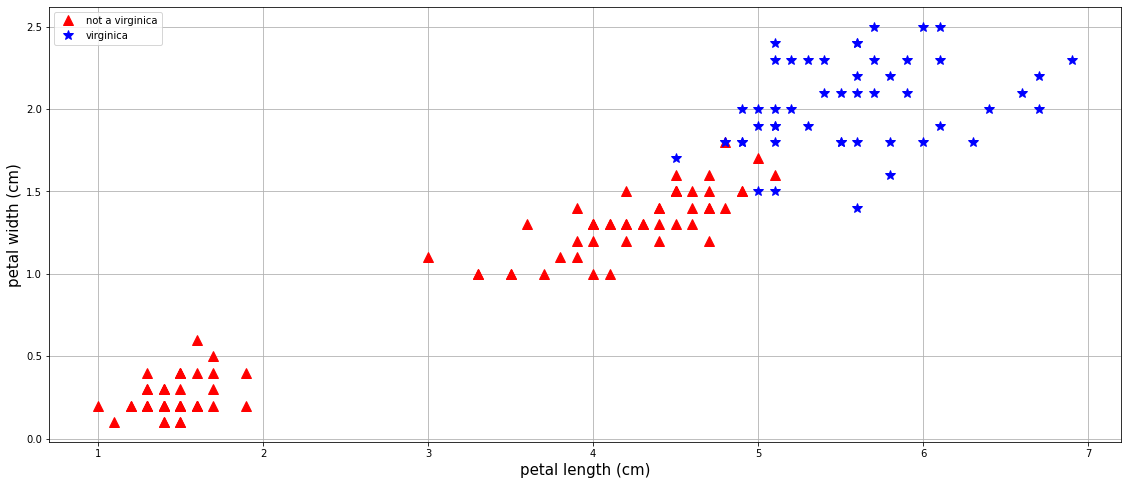

In [41]:
fig = plt.figure(figsize=(19.20, 8.))
ax = plt.axes()
ax.plot(X[y==0, 0], X[y==0, 1], 'r^', markersize=10, label='not a %s'%data.target_names[2])
ax.plot(X[y==1, 0], X[y==1, 1], 'b*', markersize=10, label=data.target_names[2])
ax.set_xlabel(data.feature_names[2], fontsize=15)
ax.set_ylabel(data.feature_names[3], fontsize=15)
ax.legend(loc='upper left')
ax.grid(True)
plt.show()

<p>And build our model and sklearn model.</p>

In [42]:
log_reg = LogRegression()
history, weights_history = log_reg.fit(X.T, np.array([y]))

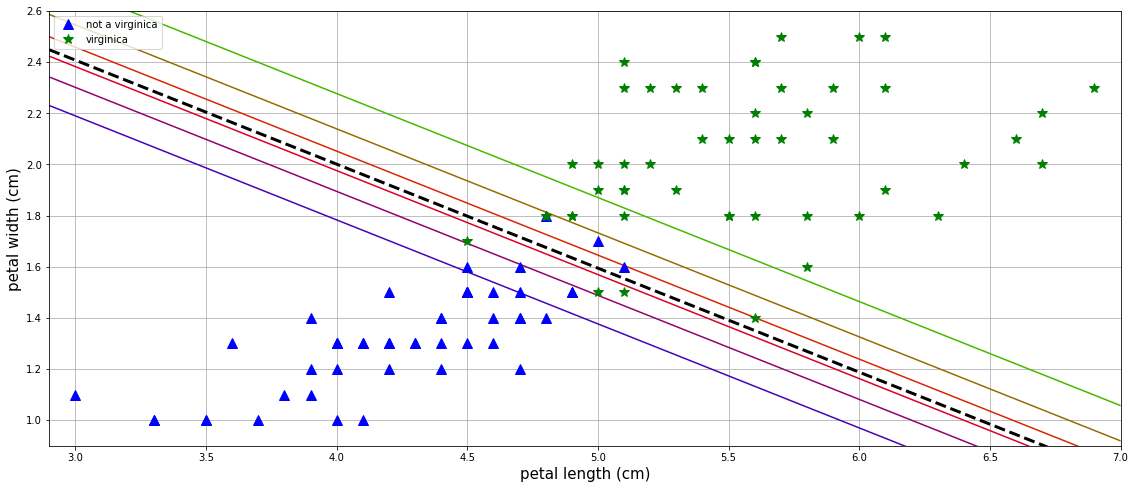

In [43]:
fig = plt.figure(figsize=(19.20, 8.))
ax = plt.axes()
ax.plot(X[y==0, 0], X[y==0, 1], 'b^', markersize=10, label='not a %s'%data.target_names[2])
ax.plot(X[y==1, 0], X[y==1, 1], 'g*', markersize=10, label=data.target_names[2])
left_right = np.array([2.9, 7])
boundary = -(log_reg.w[0][0] * left_right + log_reg.b[0]) / log_reg.w[0][1]
ax.plot(left_right, boundary, "k--", linewidth=3)
x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new.T)

zz = y_proba[:, 1].reshape(x0.shape)
contour = ax.contour(x0, x1, zz, cmap=plt.cm.brg)
ax.set_xlabel(data.feature_names[2], fontsize=15)
ax.set_ylabel(data.feature_names[3], fontsize=15)
ax.legend(loc='upper left')
ax.axis([2.9, 7., 0.9, 2.6])
ax.grid(True)
plt.show()

In [44]:
log_skl.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

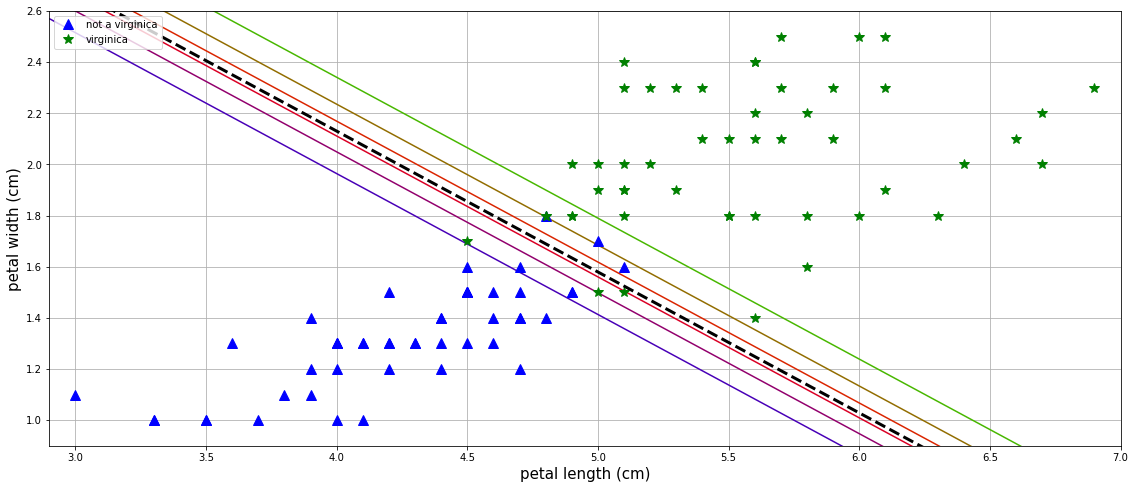

In [45]:
fig = plt.figure(figsize=(19.20, 8.))
ax = plt.axes()
ax.plot(X[y==0, 0], X[y==0, 1], 'b^', markersize=10, label='not a %s'%data.target_names[2])
ax.plot(X[y==1, 0], X[y==1, 1], 'g*', markersize=10, label=data.target_names[2])
left_right = np.array([2.9, 7])
boundary = -(log_skl.coef_[0][0] * left_right + log_skl.intercept_[0]) / log_skl.coef_[0][1]
ax.plot(left_right, boundary, "k--", linewidth=3)
x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_skl.predict_proba(X_new)

zz = y_proba[:, 1].reshape(x0.shape)
contour = ax.contour(x0, x1, zz, cmap=plt.cm.brg)
ax.set_xlabel(data.feature_names[2], fontsize=15)
ax.set_ylabel(data.feature_names[3], fontsize=15)
ax.legend(loc='upper left')
ax.axis([2.9, 7., 0.9, 2.6])
ax.grid(True)
plt.show()

In [46]:
log_reg.class_prediction(X.T).T == log_skl.predict(X)

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      

In [47]:
print('My model coefs = {0}, bias = {1}.\nsklearn\'s coef_ = {2}, intercept_ = {3}'.\
      format(log_reg.w, log_reg.b, log_skl.coef_, log_skl.intercept_))

(array([[3.23742435, 7.96224257]]),
 array([-28.88226319]),
 array([[ 5.75446795, 10.44661558]]),
 array([-45.27188876]))

<p>Here coefficients a bit different, I guess it because of different optimization algorithms, or maybe it because of sklearn usage of regularization by default. But as a result my model's predictions and sklearn's predictions are the same.</p>

<h2>Multinomial Logistic Regression</h2>

<p>In the latter case, we will build a multi-class classification model. For example, if we have more than two types of iris. In this case, a loss function called cross entropy is minimized: \begin{equation} \large -\frac{1}{n} \sum_{i=1}^{n} \sum_{k=1}^{K} y_{k}^{i} log(\hat{p_{k}^{i}}) \end{equation} the $y_{k}^{i}$ value is 1 if the target feature for the $i$-th sample is k, otherwise it is 0.</p>

<p>Now let's describe in more detail how it works. To begin with, the weighted sum of points for each class is calculated: \begin{equation} \large s_{k}(x) = X \cdot w^{k} + b \end{equation} Here you should pay attention to the fact that each class has its own parameter vector. For example, if there are 3 classes and 2 features, then $W$ will consist of 3 columns $w^{k}$ with 2 coefficients in each column!<br>Let's continue following our example, if we have 3 classes and 2 features with a length of 150, then after scoring points we should get a matrix with a size of 150 by 3.<br> Further, having a weighted sum of points for each class, we can turn these points into the probability of being assigned to each class, using the softmax function: \begin{equation} \large\hat{p_{k}} = \frac{exp(s_{k}(x))}{\sum_{q=1}^{K}exp(s_{q}(x))} \end{equation} Here you should pay attention to the fact that summation is separate for each class, that is, having a matrix of weighted sums of 150 by 3, summation must be carried out by columns, and as a result, the matrix 150 by 3 is divided into a matrix-vector 1 by 3.<br>And it is the resulting normalized probability matrix that we use to minimize the loss function and calculate the gradient.</p>

In [201]:
class MLogRegression():
    
    def init_EMAs(self, input_size, output_size):
        self.EMA_adam1_w = np.zeros((input_size, output_size), dtype=float)
        self.EMA_adam2_w = np.zeros((input_size, output_size), dtype=float)
        self.EMA_adam1_b = np.zeros((1, output_size), dtype=float)
        self.EMA_adam2_b = np.zeros((1, output_size), dtype=float)
    
    def init_weights(self, input_size, output_size): 
        self.w = np.random.normal(0, 0.01, size=(input_size, output_size))
        self.b = np.zeros((1, output_size), dtype=float)
        
    def make_targets(self, y):
        frame = pd.DataFrame(y, columns=['target'])
        for i in range(frame.max()[0] + 1):
            frame[str(i)] = frame[frame.target == i].target
        return frame.applymap((lambda x: 1.0 if not np.isnan(x) else 0)).drop(['target'], axis=1).to_numpy()
    
    def probability(self, X):
        return np.exp(self.predict(X)) / (np.exp(self.predict(X))).sum(axis=1).reshape(-1, 1) #softmax
    
    def CrossEntropyLoss(self, X, y):
        return -(self.probability(X) * y).sum() / X.shape[0]
    
    def w_grad(self, X, y):
        helper_list = []
        for i in range(y.shape[1]):
            helper_list.append((((self.probability(X) - y)[:, i, np.newaxis] * X).sum(axis=0) / X.shape[0]).tolist())
        return np.array(helper_list).T
    
    def b_grad(self, X, y):
        return (self.probability(X) - y).sum(axis=0) / X.shape[0]
        
    def fit(self, X, y, lr=3e-4, num_epochs=100000, beta1=0.9, beta2=0.999, eps=10e-9):
        self.init_weights(X.shape[1], y.max() + 1)
        self.init_EMAs(X.shape[1], y.max() + 1)
        y = self.make_targets(y)
        loss_history = []
        weights_history = []
        loss_history.append(self.CrossEntropyLoss(X, y))
        weights_history.append([self.w.tolist(), self.b.tolist()])
        for _ in range(num_epochs):
            next_EMA1_w = (1 - beta1) * self.w_grad(X, y) + beta1 * self.EMA_adam1_w
            next_EMA2_w = (1 - beta2) * (self.w_grad(X, y)) ** 2 + beta2 * self.EMA_adam2_w
            next_EMA1_b = (1 - beta1) * self.b_grad(X, y) + beta1 * self.EMA_adam1_b
            next_EMA2_b = (1 - beta2) * (self.b_grad(X, y)) ** 2 + beta2 * self.EMA_adam2_b
            self.w -= lr * next_EMA1_w / (np.sqrt(next_EMA2_w) + eps)
            self.b -= lr * next_EMA1_b / (np.sqrt(next_EMA2_b) + eps)
            self.EMA_adam1_w = next_EMA1_w
            self.EMA_adam2_w = next_EMA2_w
            self.EMA_adam1_b = next_EMA1_b
            self.EMA_adam2_b = next_EMA2_b
            if _ % 100 == 0:
                loss_history.append(self.CrossEntropyLoss(X, y))
                weights_history.append([self.w.tolist(), self.b.tolist()])           
        return np.array(loss_history), np.array(weights_history)

    def predict(self, X):
        return (X @ self.w + self.b)
    
    def class_prediction(self, X):
        return self.predict(X).argmax(axis=1)

<p>For building the model we will use two features and 3 targets.</p>

In [233]:
X = data["data"][:, (2, 3)]
y = data.target

<p>Let's build and compare our model with the sklearn model.</p>

In [209]:
mlog_reg = MLogRegression()
history, weights_history = mlog_reg.fit(X, y)

In [218]:
mlog_skl = LogisticRegression(penalty='none', multi_class='multinomial')
mlog_skl.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [222]:
mlog_reg.class_prediction(X) == mlog_skl.predict(X)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

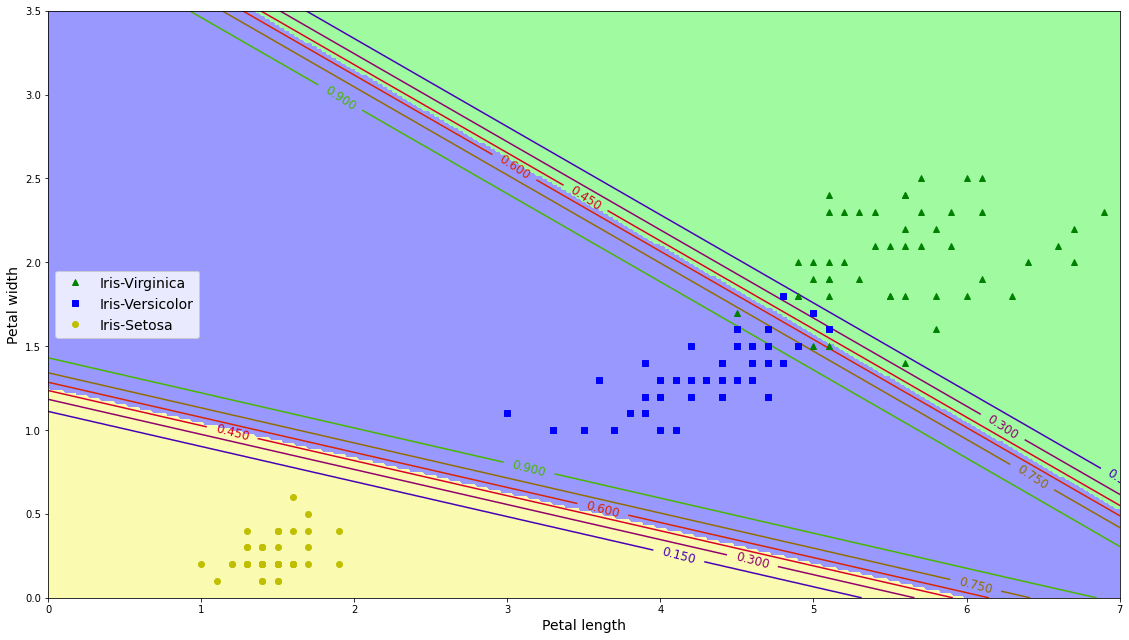

In [216]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = mlog_reg.probability(X_new)
y_predict = (X_new @ mlog_reg.w + mlog_reg.b).argmax(axis=1)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(19.20, 10.80))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

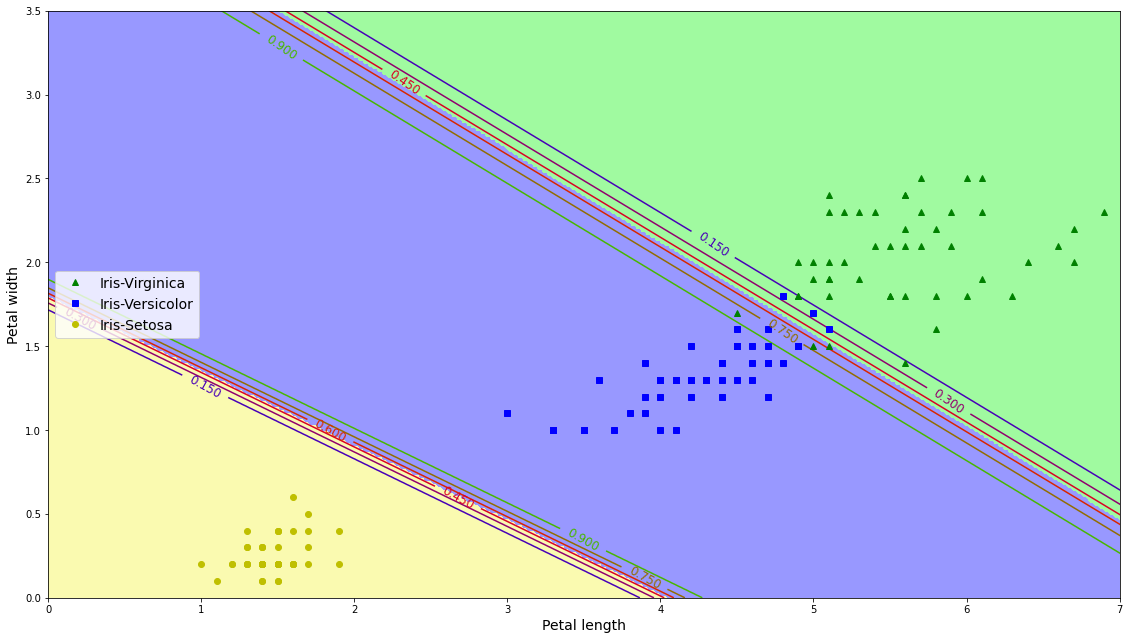

In [220]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = mlog_skl.predict_proba(X_new)
y_predict = mlog_skl.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(19.20, 10.80))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

In [239]:
print('My model coefs = {0}, bias = {1}.\nsklearn\'s coef_ = {2}, intercept_ = {3}'.\
      format(mlog_reg.w.T, mlog_reg.b, mlog_skl.coef_, mlog_skl.intercept_))

My model coefs = [[ -4.802374   -11.3801301 ]
 [ -2.22489084   0.94748637]
 [  2.94576632  10.79162939]], bias = [[ 28.38873785  12.95356499 -28.46999464]].
sklearn's coef_ = [[ -8.35272804 -17.97102473]
 [  1.29900608   3.76191168]
 [  7.05372197  14.20911305]], intercept_ = [ 41.12285302   2.07559001 -43.19844303]


In [32]:
with open('./style.css') as f:
    style = f.read()
HTML(style)